# B20-03 Lev Kozlov

## Task 1 - detect parameters of line using RANSAC algorithm

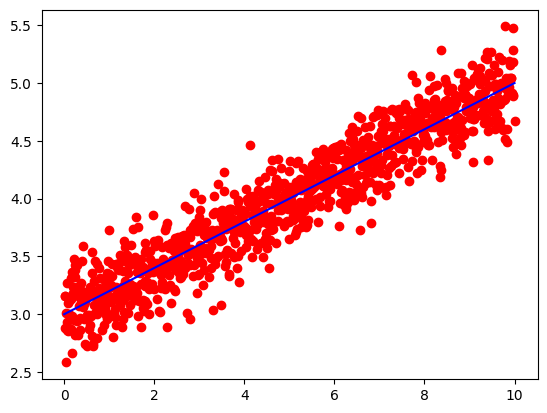

In [75]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 10, 1000)

y = 0.2 * t + 3

# add noise
dataset = np.array([t, y])
perp = np.array([[-0.2], [3]])
perp /= np.linalg.norm(perp)
dataset_noisy = dataset + perp * np.random.normal(0, 0.2, y.shape)

plt.scatter(dataset_noisy[0], dataset_noisy[1], color='red')
plt.plot(dataset[0], dataset[1], color='blue')

In [76]:
def line(p0, p1):
    # accept two points and return a, b, c to have line in form ax + by + c = 0
    return p1[1] - p0[0], p1[0] - p0[0], p0[0] * p1[1] - p1[0] * p0[1]

def estimate_line(points):
    n = len(points)

    max_iter = 1000

    # distance to classify point as inlier
    eps = 2

    min_good_fit = 0

    iter = 0
    best_err = np.inf

    while iter < max_iter:
        maybeInliers = points[np.random.choice(list(range(len(points))), 2)]
        a, b, c = line(maybeInliers[0], maybeInliers[1])

        alsoInliers = 0
        dist_err = 0

        samples = points[np.random.choice(list(range(len(points))), int(n * 0.3))]

        normal = np.array([a, b])

        dist = np.abs(normal @ samples.T + c) / np.sqrt(normal @ normal.T)

        dist_err = np.sum(dist)
        inliers = np.count_nonzero(dist < eps)

        if inliers > min_good_fit and dist_err < best_err:
            dominantLine = (a, b, c)
            best_err = dist_err
            print(dominantLine, best_err)

        iter += 1

    return dominantLine

solution = estimate_line(dataset_noisy.T)

(-4.1931315023143965, -0.5103716466246393, 2.86672493088448) 1422.5763897190918
(4.070410993637786, 6.392489832063389, -18.128989884847268) 1131.6965780650485
(3.3680577031724526, 6.991128296623568, -21.40344107748313) 938.7920118614583
(0.356297000769362, 2.9730622589273157, -8.61474498181413) 487.008744064452
(-0.25149681271295465, -2.989409832811958, 8.855949611297007) 455.21118449631444
(0.20092546884520246, 3.914209695199684, -14.78144531738474) 215.4234119492279
(-0.882186004916087, 2.6353914356996384, -6.08668432287169) 100.28996800258247
(-0.6663662458002282, 3.6133830815340087, -10.72428392534114) 58.25334889099061
(0.17334966518893147, -0.8580073264173813, 2.590599430543337) 49.57857893305644


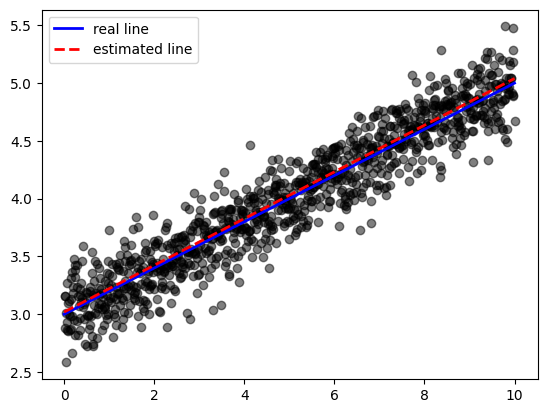

In [85]:
a, b, c = solution

new_line = -a / b * t - c / b

plt.scatter(dataset_noisy[0], dataset_noisy[1], color='black', alpha=0.5)
plt.plot(dataset[0], dataset[1], color='blue', lw=2, label='real line')
plt.plot(t, new_line, color='red', lw=2, linestyle='dashed', label='estimated line')
plt.legend()

# Task 2 - detect and visualize object from 3D point cloud

For this experiment I made a shot from Intel Realsense d435.

A small block with height 20mm placed and I plan to detect it.

## Detect & remove redundant 3D point clouds that belong to environment

I assume that points have no noise and all points belong to environment

![Alt text](hw5/presentation0.png)

![Alt text](hw5/presentation1.png)

I had to use python3.7 and conda environment to run everything

In [86]:
# !pip3 install open3d

In [1]:
import numpy as np
import open3d as o3d

cloud = o3d.io.read_point_cloud('hw5/00.ply')
points = np.asarray(cloud.points)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Detect & remove points that belong to floor using RANSAC


In [16]:
points.shape

(861658, 3)

In [15]:
np.min(points[:, 2]), np.max(points[:, 2])

(-0.6580000519752502, -0.593000054359436)

In [23]:
def plane(p0, p1, p2) -> np.ndarray:
    u, v = p1 - p0, p2 - p0
    normal = np.cross(u, v)
    normal = normal / np.linalg.norm(normal)
    d = -p0.dot(normal)

    return normal, d

plane(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([1, 1, 0]))

(array([ 0.,  0., -1.]), -0.0)

In [26]:

def estimate_plane(points):
    n = len(points)

    max_iter = 150

    # distance to classify point as inlier
    eps = 0.005

    min_good_fit = 0

    iter = 0
    best_err = np.inf

    while iter < max_iter:
        maybeInliers = points[np.random.choice(list(range(len(points))), 3)]
        normal, d = plane(maybeInliers[0], maybeInliers[1], maybeInliers[2])

        alsoInliers = 0
        dist_err = 0

        samples = points[np.random.choice(list(range(len(points))), int(n * 0.3))]

        dist = np.abs(normal @ samples.T + d) / np.sqrt(normal @ normal.T)

        dist_err = np.sum(dist)
        inliers = np.count_nonzero(dist < eps)

        if inliers > min_good_fit and dist_err < best_err:
            dominantPlane = (normal, d)
            best_err = dist_err
            print(dominantPlane, best_err)

        iter += 1

    return dominantPlane

solution = estimate_plane(points)

(array([-0.529021  ,  0.75319357,  0.39094274]), 0.25396164626306245) 36846.67545706701
1
(array([-0.00341356, -0.09704195,  0.99527444]), 0.6212916163191533) 899.3235780653482
2
(array([-0.01617823,  0.09263557, -0.99556864]), -0.622487022949851) 747.6689655748243
3
4
5
(array([-0.0098745 ,  0.09041928, -0.99585483]), -0.6227087499637208) 738.7283895003443
6
7
8
9
10
11
12
13
14
(array([-0.00754755,  0.09558043, -0.9953931 ]), -0.6213428573169802) 631.7684971443249
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [39]:
normal, d = solution

# remove all points which are not on plane
inliers = np.abs((normal @ points.T + d)) / np.sqrt(normal @ normal.T)
filtered = points[inliers > 0.015] # height of cube is 0.02

filtered.shape

(1666, 3)

In [40]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(filtered)
o3d.io.write_point_cloud("hw5/filtered.ply", pcd)

True

# Results

As we see in this image, cube is pretty much filtered.

![Alt text](hw5/result.png)
![Alt text](hw5/presentation0.png)

code for showing same, it will not work in jupyter notebook:

```python
import numpy as np
import open3d as o3d

def main():
    points = o3d.io.read_point_cloud('hw5/filtered.ply')
    points.paint_uniform_color(np.array([0.1, 0.1, 0.1]))
    pcd = o3d.io.read_point_cloud('hw5/00.ply')
    pcd.paint_uniform_color(np.array([1, 0.706, 0]))
    o3d.visualization.draw_geometries([pcd, points], 'Demonstration', 1080, 720)
    

if __name__ == "__main__":
    main()
```